## Importing libaries

In [ ]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_preprocess import preprocess
from src.support_eda import plot_relation_tv
from src.support_clustering import *

## Data loading and preprocess

In [2]:
df = pd.read_csv('../data/raw/WrestlingWorldTournament.csv', index_col=0)

df.head()

,name,gender,age,height,nationality,weight,sports,hours_per_day,strength,agility,mental,federation,year_start,rank
0,Aaron Peavy,Female,41,165.0,England,82,"Boxing, MMA",3,7,8,7,Fight Zone Wrestling,1989,42
1,Abe Rutland,Male,36,185.0,Japan,100,Judo,0,8,5,9,World Wrestling Entertainment,2006,161
2,Adrian Quinn,Male,29,178.5,Japan,93,Karate,4,8,8,7,World Wrestling Entertainment,2012,153
3,Alan Beckham,Male,39,187.5,Japan,107,Judo,3,7,6,8,Fight Zone Wrestling,2003,252
4,Albertha Rodriguez,Female,29,158.0,USA,72,MMA,1,5,7,7,Consejo Global de Lucha Libre,2012,360


### Let’s carry out the preprocessing

* Remove the columns we do not want to consider.

* Select the encoding methods for categorical variables.

* Select the scaling method.

In [3]:
cols = ['name', 'sports', 'year_start', 'federation']

encoding_methods = {"onehot": ['gender'],
                    "target": [],
                    "ordinal" : {},
                    "frequency": ['nationality']
                    }

scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, columns_drop=cols)

---

## K-means

Let us begin by evaluating the K-Means algorithm.

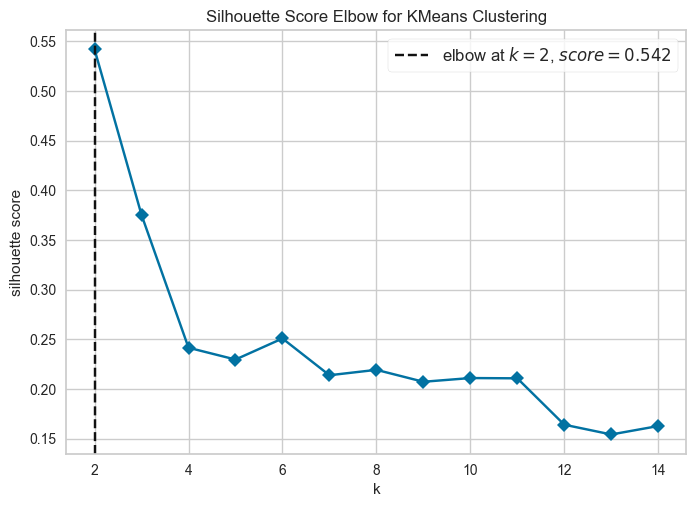

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [4]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df_scaled)
visualizer.show()

According to our data, the optimal number is 2 clusters. The silhouette score is 0.48, which is reasonably good. Closer to 1 would indicate more well-defined clusters.

We will now execute the K-means algorithm with 2 clusters.

In [5]:
model_kmeans = KMeans(n_clusters=2)

km_fit = model_kmeans.fit(df_scaled)
labels = km_fit.labels_

### Metrics

In [6]:
clustering_metrics(df_scaled, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.541864,0.743419,235
1,0.541864,0.743419,265


Now let's look at the characteristics of each cluster to see how we can interpret them.

In [7]:
df_kmeans = df_scaled.copy()

df_kmeans['cluster'] = km_fit.labels_

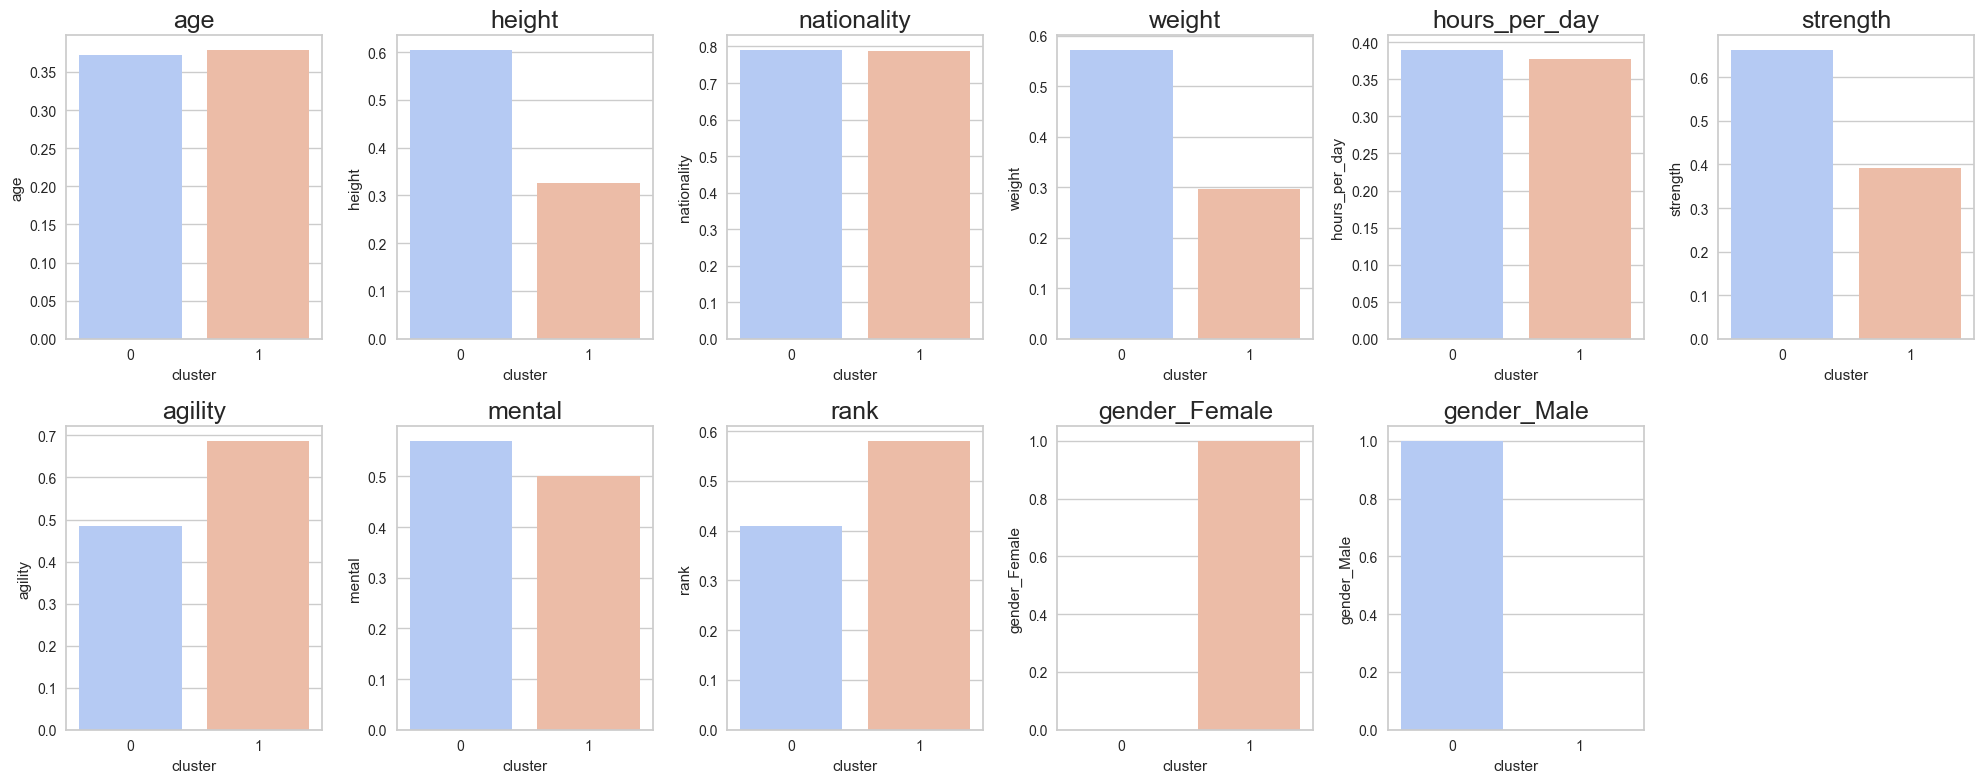

In [8]:
plot_clusters(df_kmeans)

We can clearly see that they have been classified by gender. In one cluster, we have men, and in the other, women.

Let's create a radar plot.

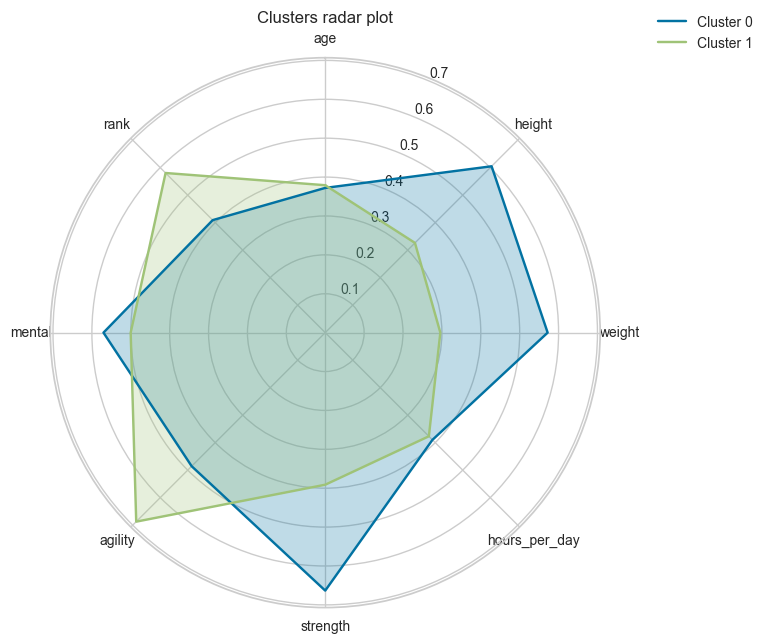

In [9]:
# Select variables to display in radar plot
variables = ['age',
            'height',
            'weight',
            'hours_per_day',
            'strength',
            'agility',
            'mental',
            'rank']

plot_radar(df_kmeans, variables)

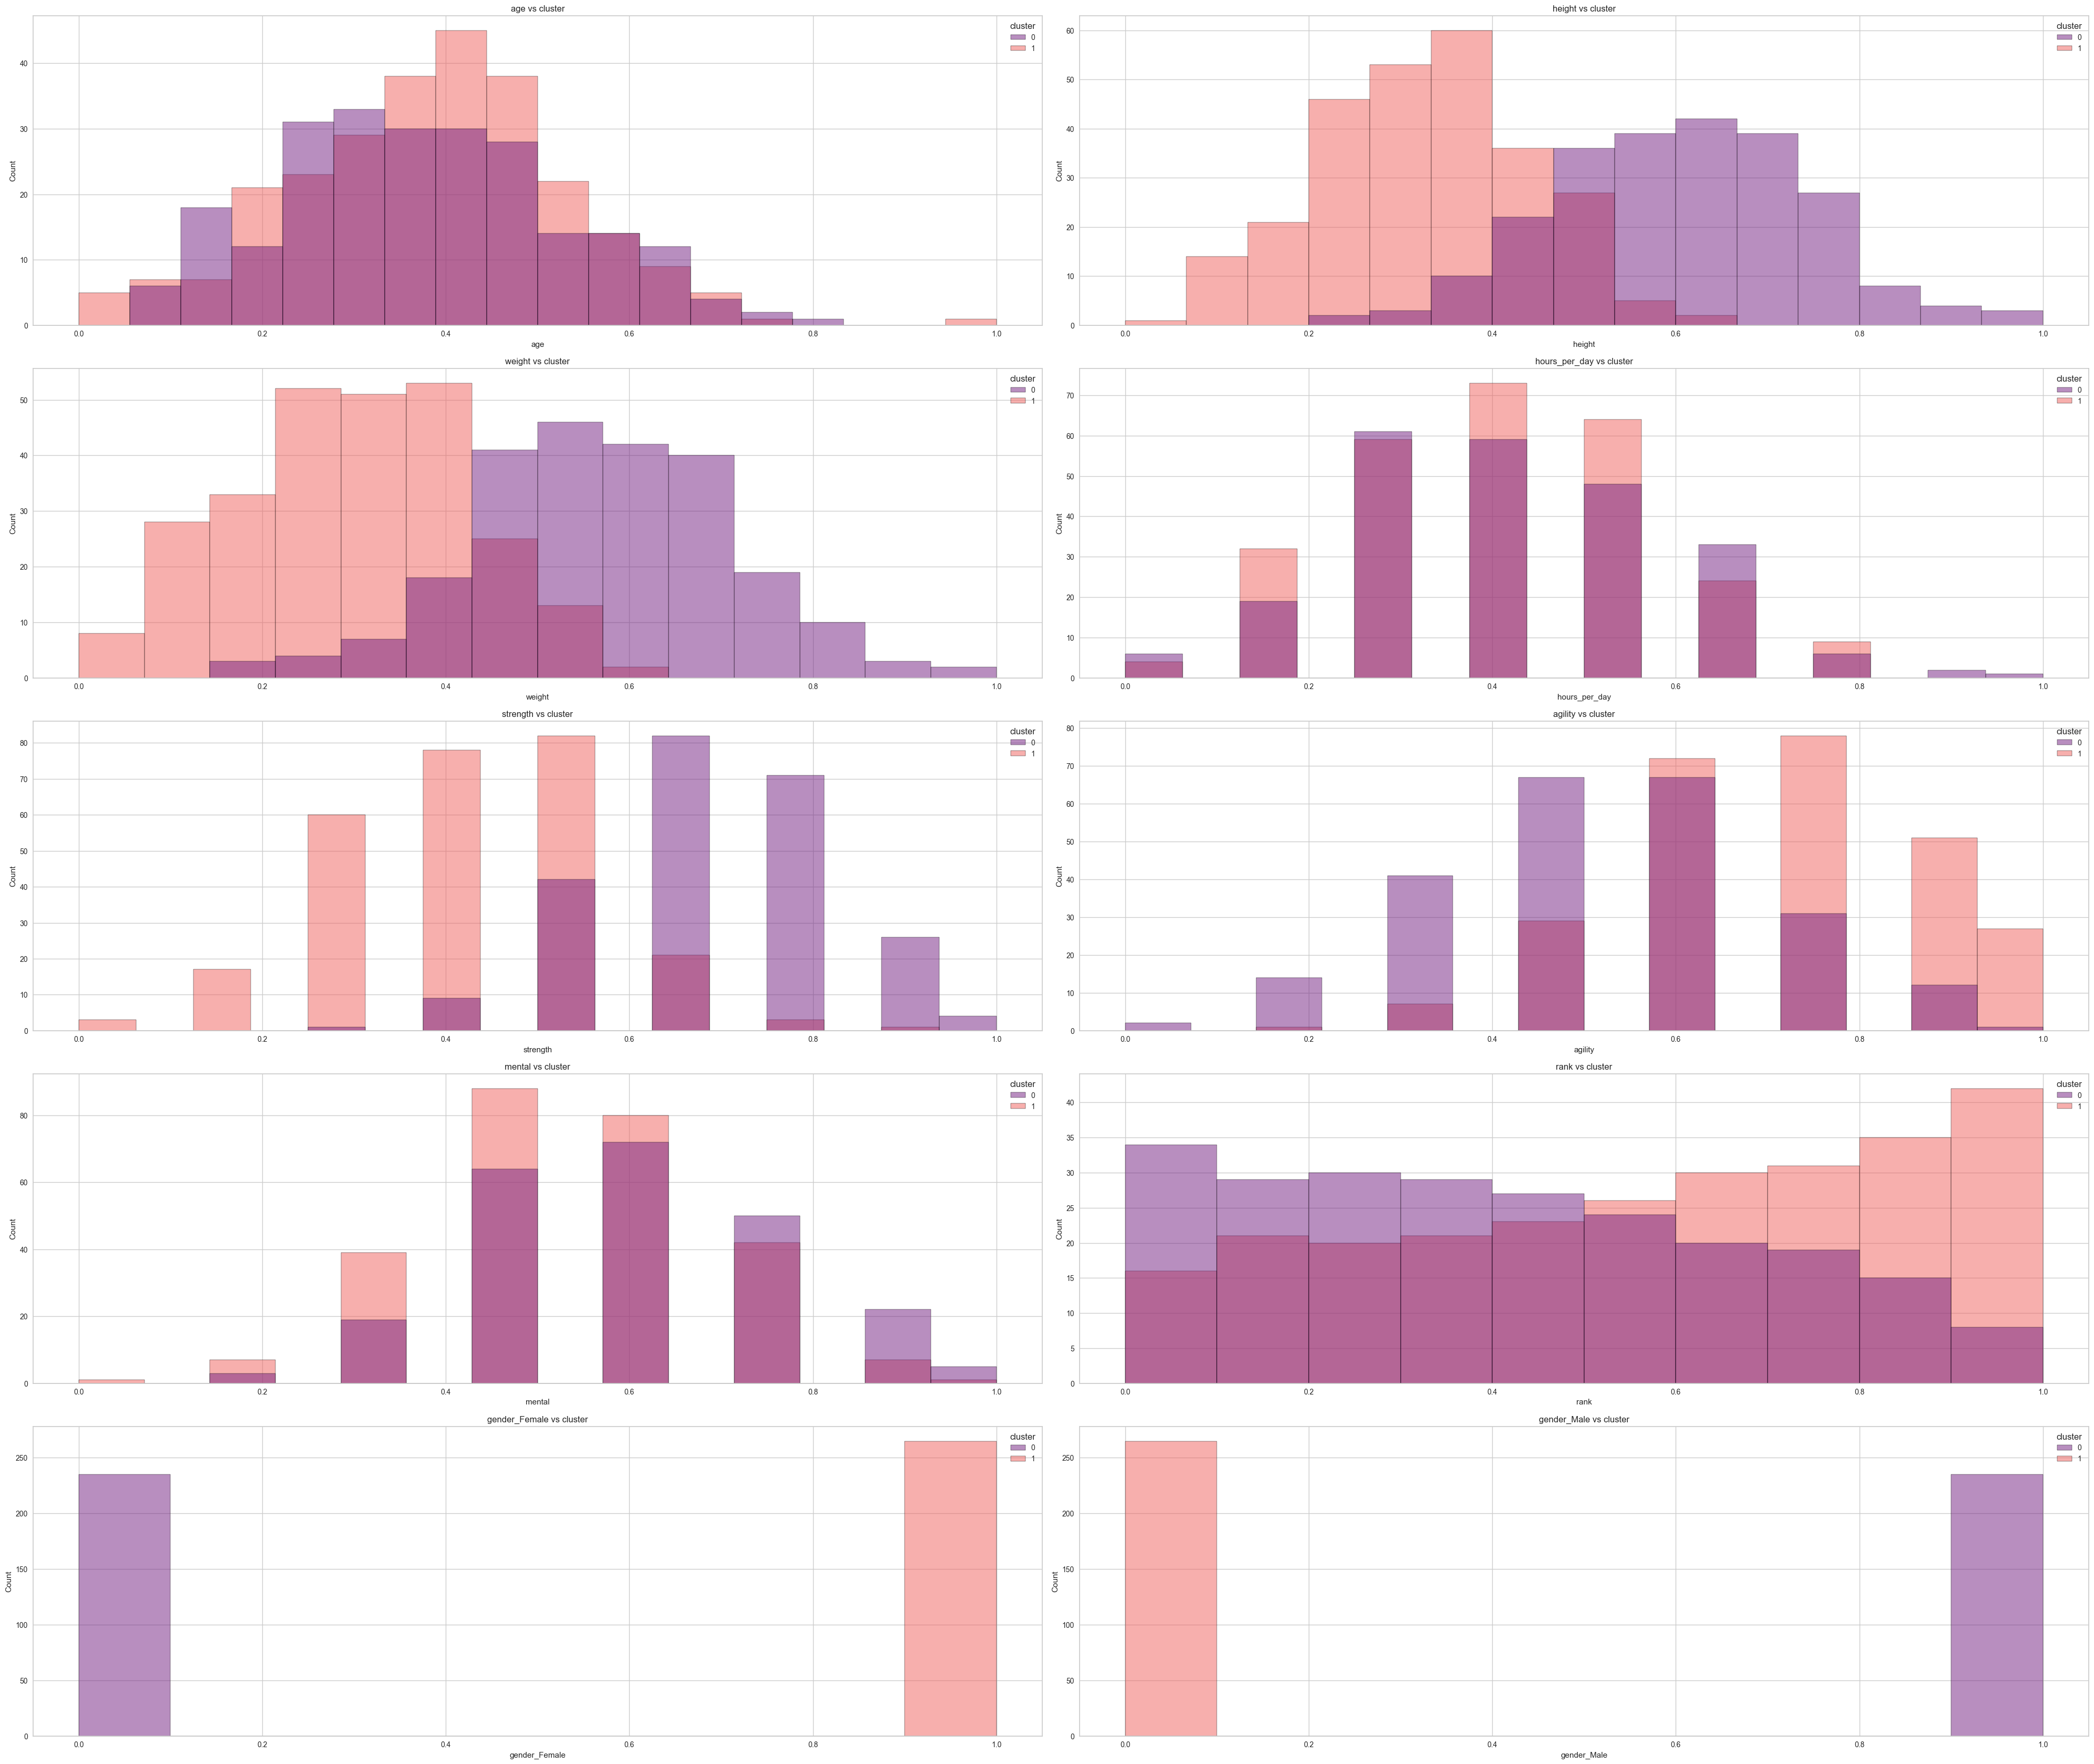

In [10]:
plot_relation_tv(df_kmeans.drop(columns=['nationality']), 'cluster', size=(40, 40), n_cols = 2)

The results confirm the initial analysis we had considered. 

In these graphs, the differences in the distribution of `rank`, `strength`, `height`, and `weight` are more noticeable, with slight differences in the rest of the variables.

---

## Agglomerative clustering

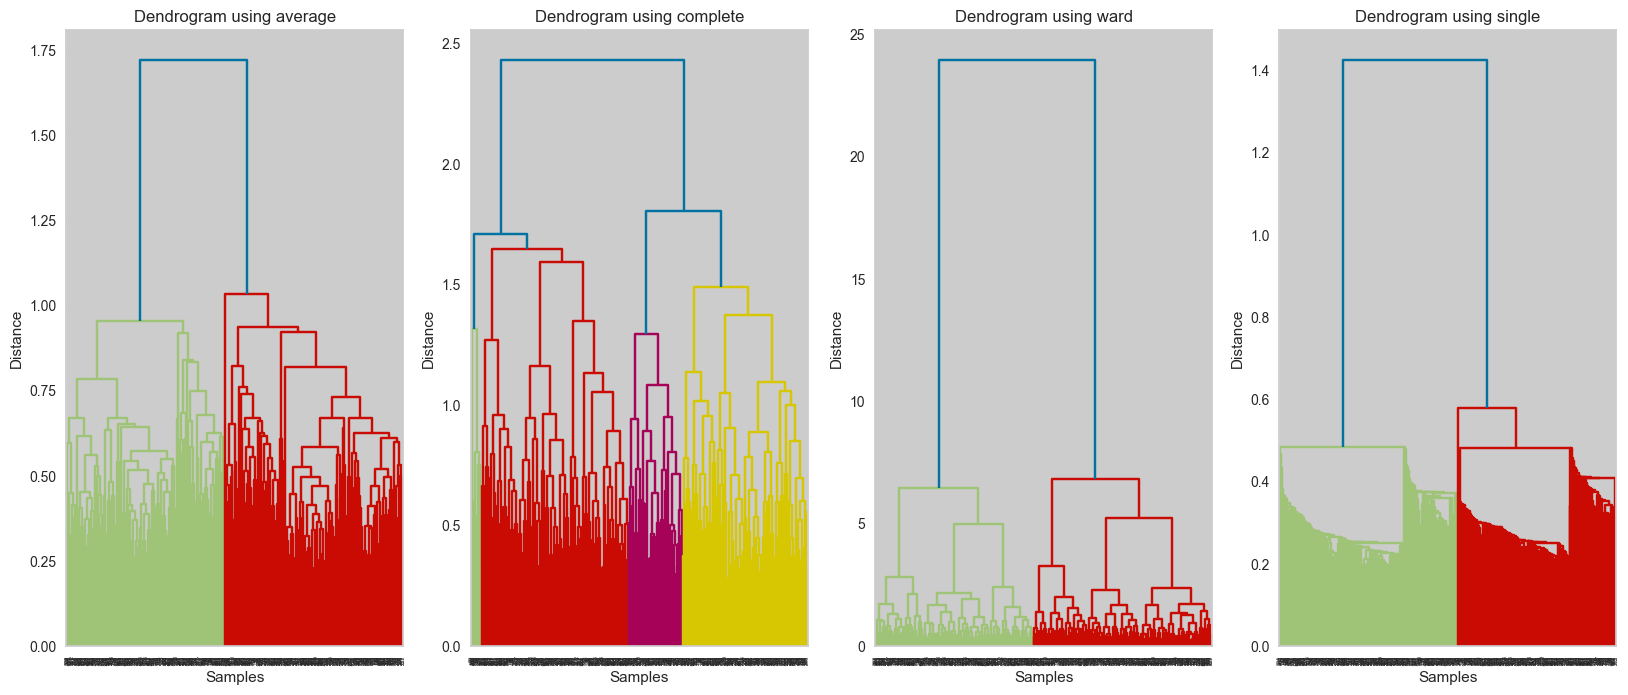

In [11]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)

According to the `complete` method, we have 4 clusters, whereas the other methods provide 2. Using the `K-means` algorithm, we obtained 2 distinct clusters, which makes sense to us.

In [12]:
results_df = agglomerative_methods(df_copy)

Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.


In [13]:
best_model = results_df.sort_values(by='ranking_score', ascending=False).iloc[0]

best_model

linkage                         complete
metric                            cosine
silhouette_score                0.779534
davies_bouldin_index            0.743419
cluster_cardinality     {0: 265, 1: 235}
n_cluster                              2
balance_score                    1.12766
ranking_score                  -1.091545
Name: 4, dtype: object

### Apply best model

In [14]:
model = AgglomerativeClustering(
    linkage=best_model['linkage'],
    metric=best_model['metric'],
    distance_threshold=None,
    n_clusters=best_model['n_cluster']
)

agglo_fit = model.fit(df_scaled)
agglo_labels = agglo_fit.labels_

In [15]:
clustering_metrics(df_scaled, agglo_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.541864,0.743419,265
1,0.541864,0.743419,235


In [16]:
df_agg = df_scaled.copy()
df_agg["cluster"] = agglo_labels

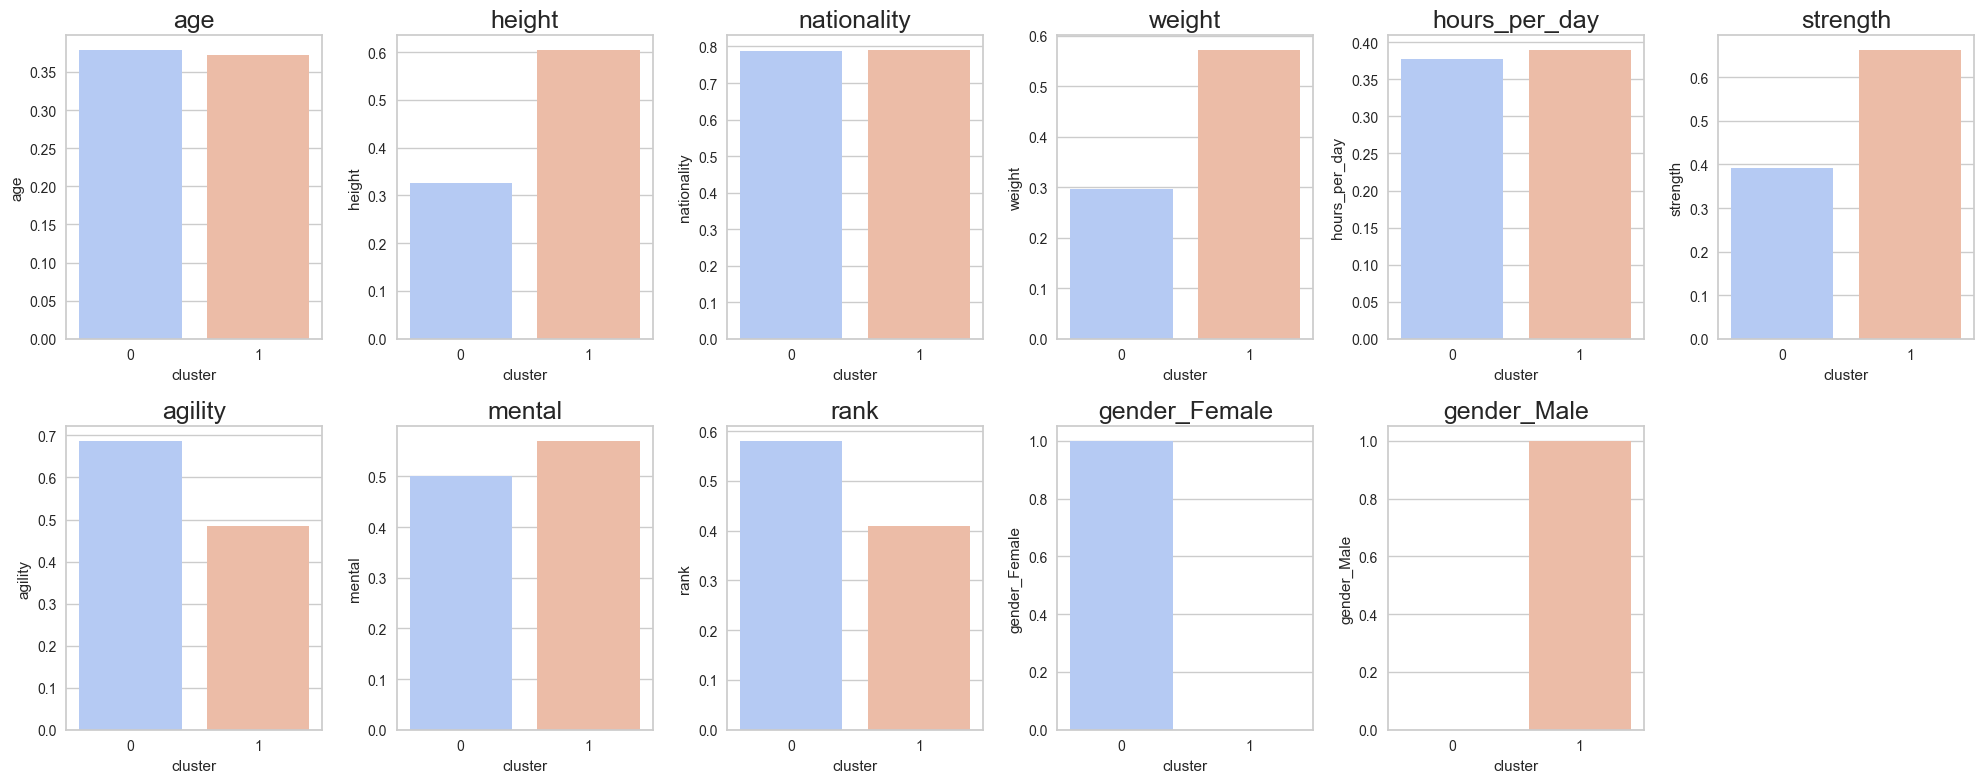

In [17]:
plot_clusters(df_agg)

The clusters created by `AgglomerativeClustering` are the same as those we obtained with `KMeans`. 

Let's also look at the radar plot.

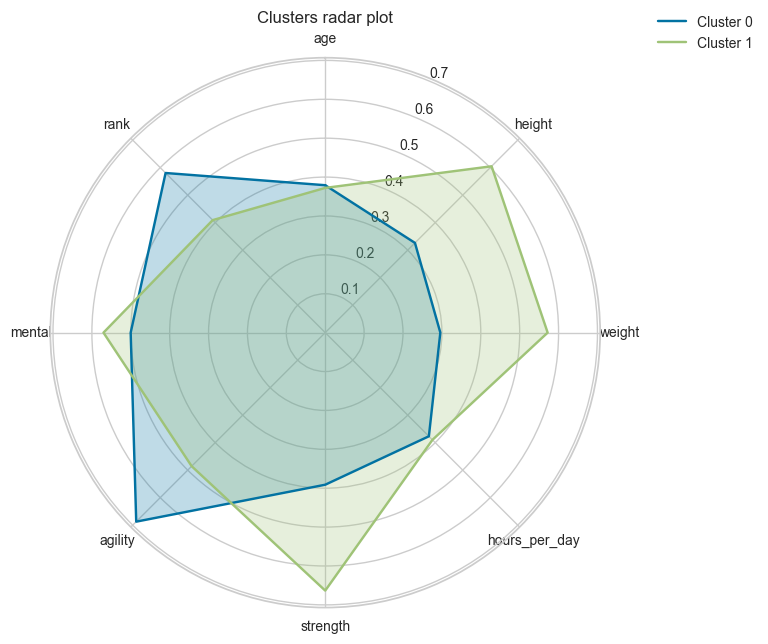

In [18]:
variables = ['age',
            'height',
            'weight',
            'hours_per_day',
            'strength',
            'agility',
            'mental',
            'rank']

plot_radar(df_agg, variables)

Again, they look the same

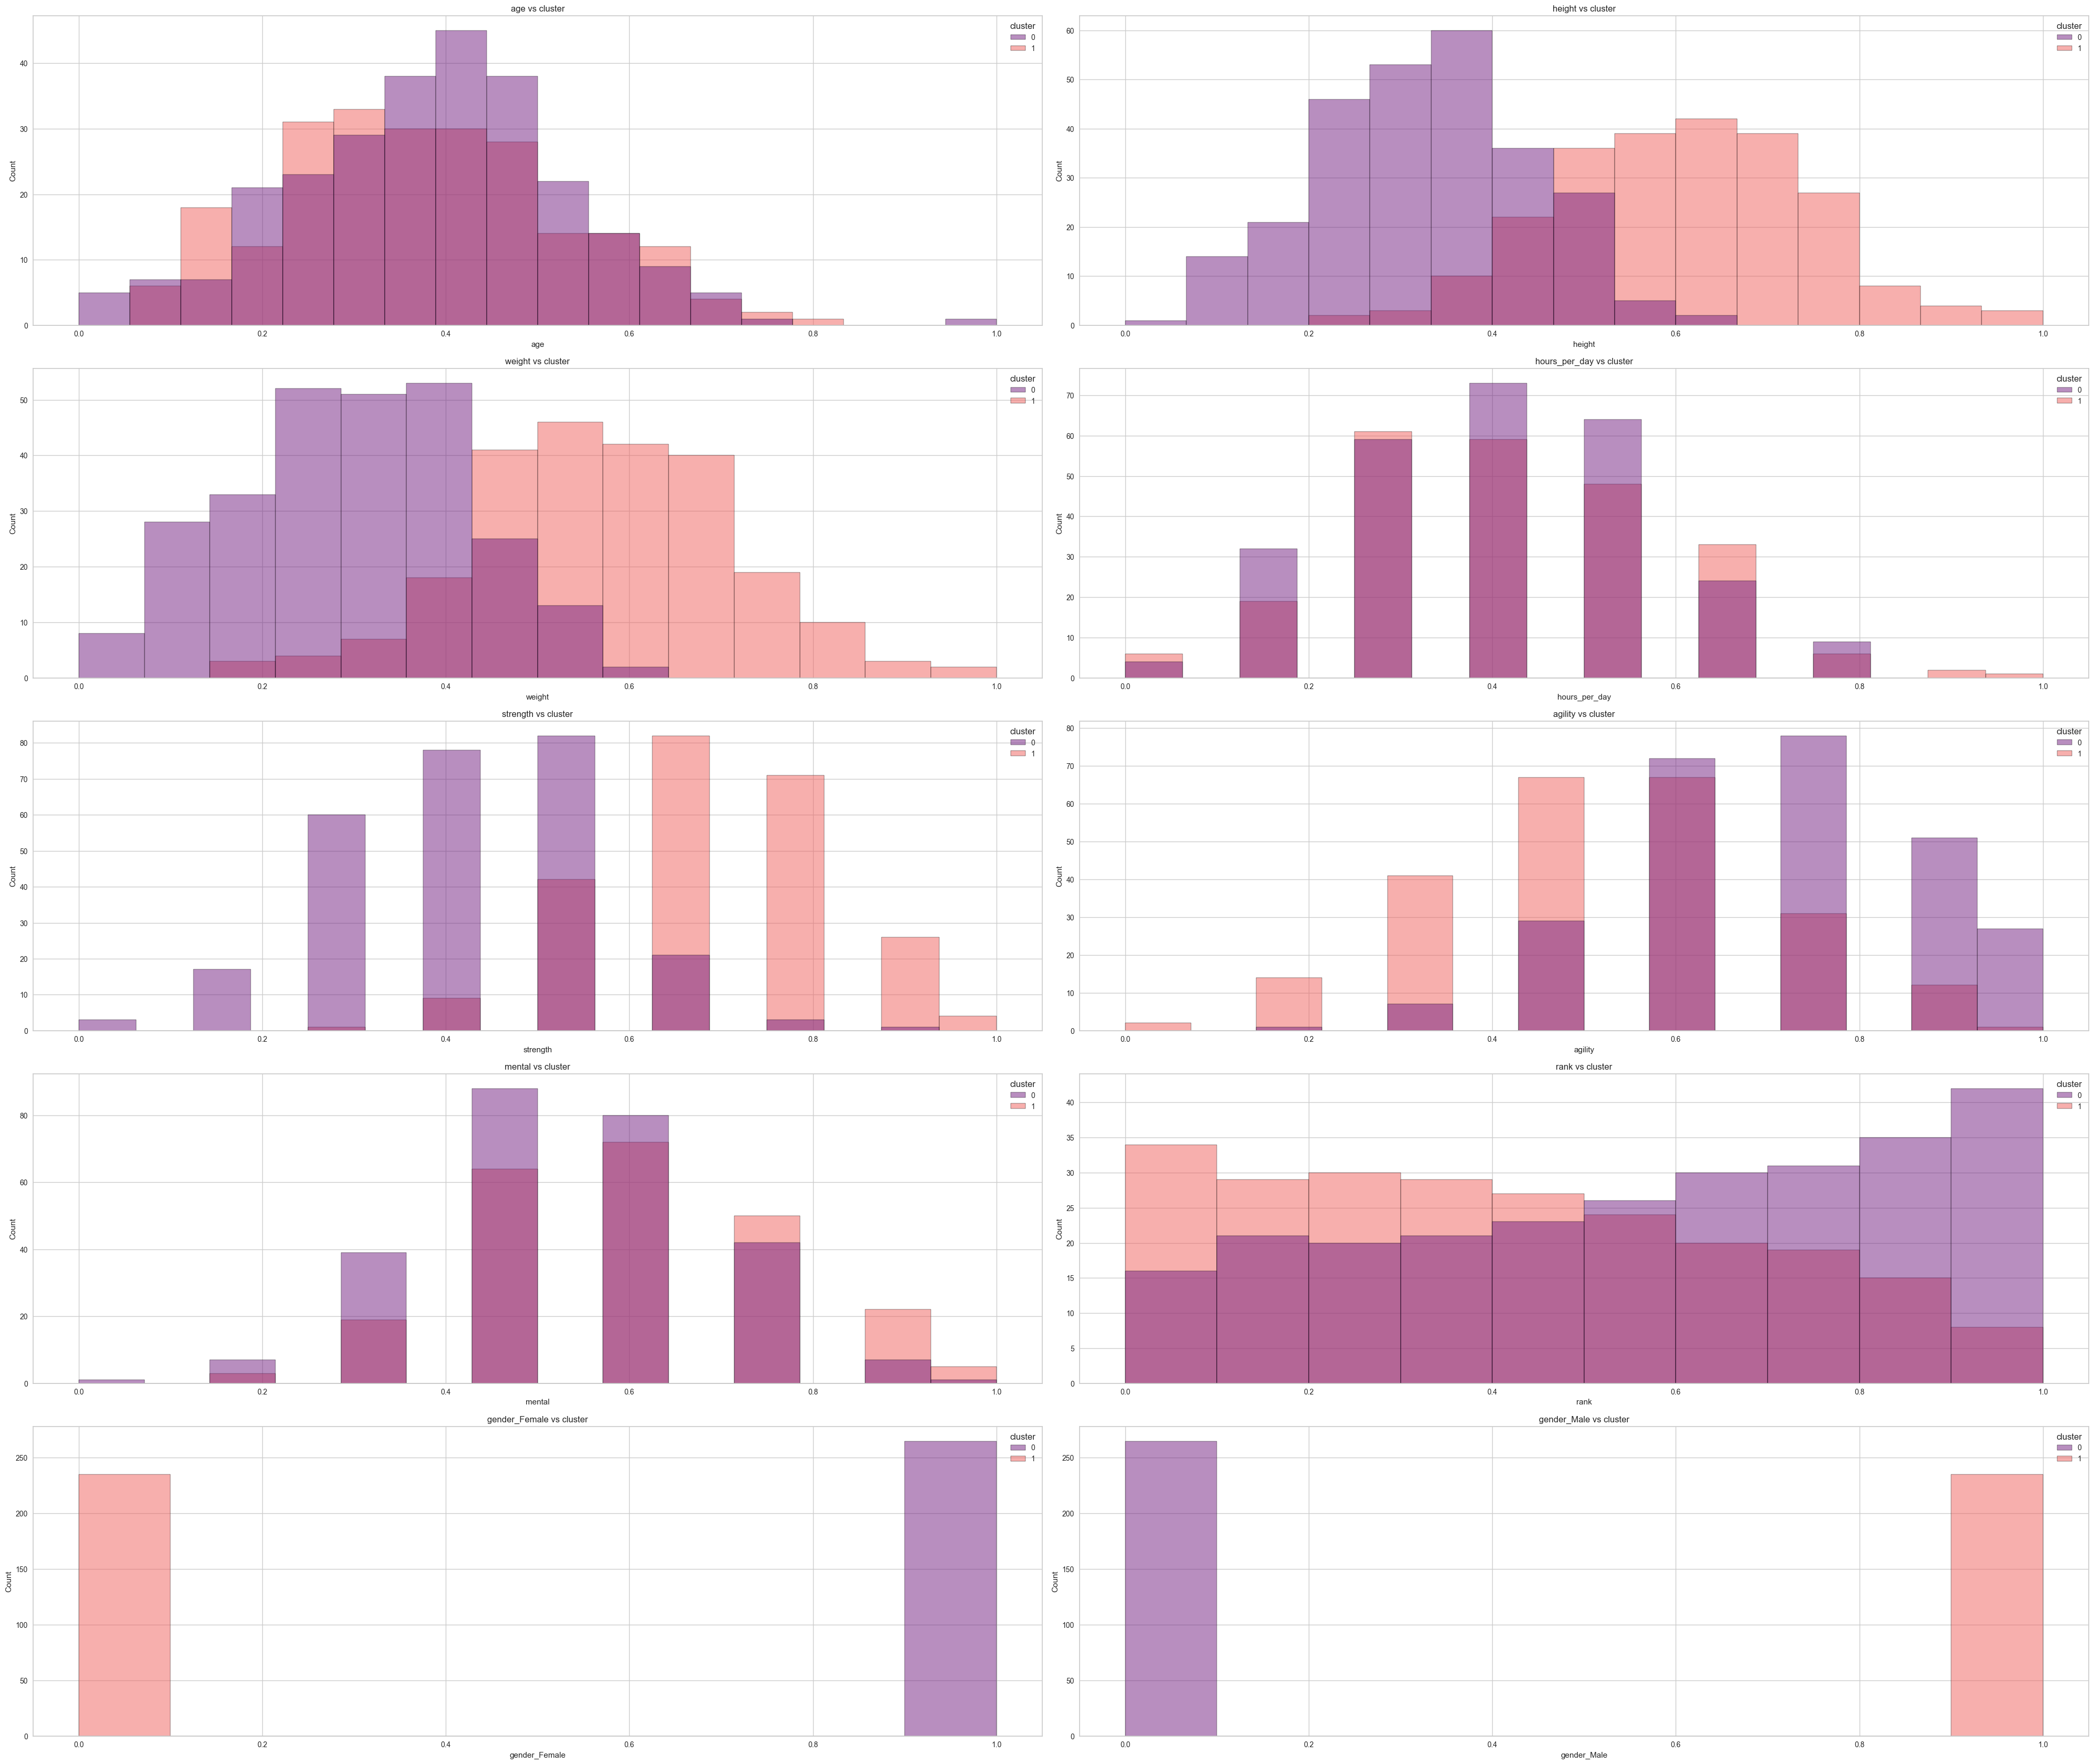

In [19]:
plot_relation_tv(df_agg.drop(columns=['nationality']), 'cluster', size=(40, 40), n_cols = 2)

---

## Spectral clustering

In [20]:
spectral_methods(df_scaled)

,n_clusters,assign_labels,silhouette_score,davies_bouldin_score,cardinality
0,2,kmeans,0.541864,0.743419,"{0: 265, 1: 235}"
1,2,discretize,0.541864,0.743419,"{0: 235, 1: 265}"
2,3,kmeans,0.362171,1.442749,"{0: 235, 1: 140, 2: 125}"
3,3,discretize,0.358636,1.440786,"{0: 130, 1: 136, 2: 234}"
4,4,kmeans,0.232474,1.465858,"{0: 128, 1: 114, 2: 165, 3: 93}"
5,4,discretize,0.226947,1.427410,"{0: 123, 1: 116, 2: 97, 3: 164}"
6,5,kmeans,0.172878,1.308067,"{0: 121, 1: 106, 2: 63, 3: 72, 4: 138}"
7,5,discretize,0.201541,1.527977,"{0: 82, 1: 110, 2: 115, 3: 83, 4: 110}"


### Apply best model

In [21]:
spectral_model = SpectralClustering(
    n_clusters=2,
    assign_labels='kmeans',
    random_state=42
    )

spectral_labels = spectral_model.fit_predict(df_scaled)

In [22]:
clustering_metrics(df_scaled, spectral_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.541864,0.743419,265
1,0.541864,0.743419,235


In [23]:
df_spectral = df_scaled.copy()
df_spectral["cluster"] = spectral_labels

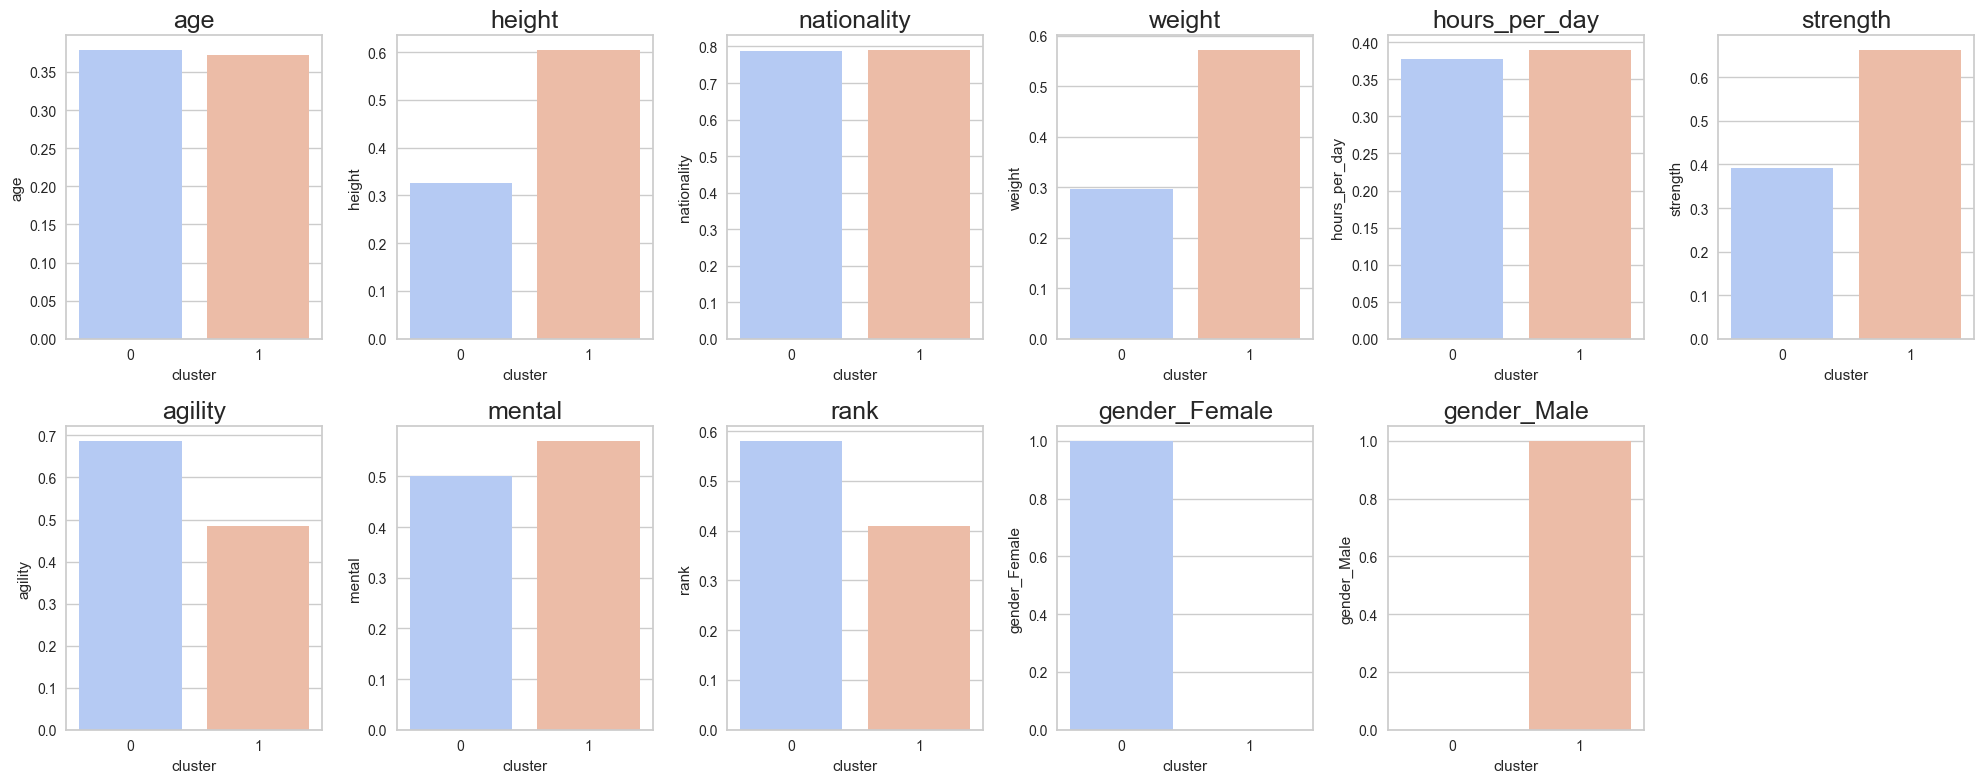

In [24]:
plot_clusters(df_spectral)

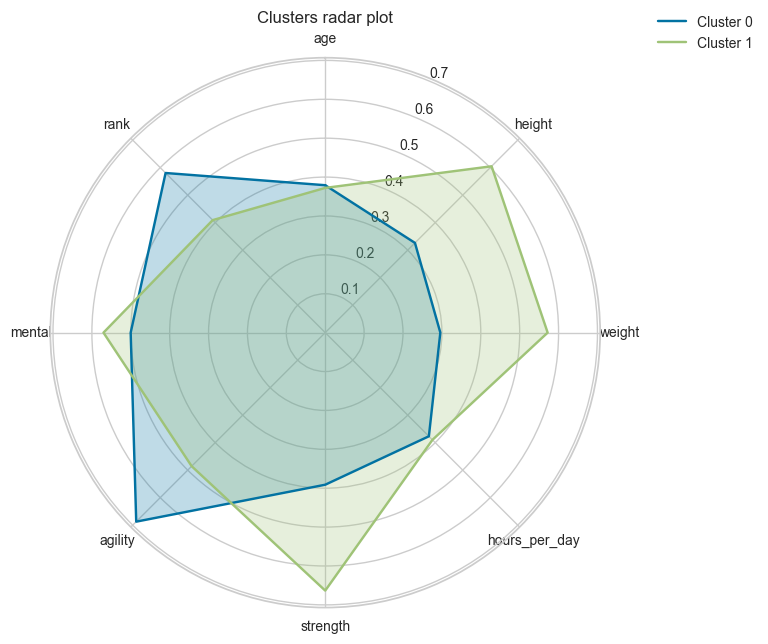

In [25]:
variables = ['age',
            'height',
            'weight',
            'hours_per_day',
            'strength',
            'agility',
            'mental',
            'rank']

plot_radar(df_spectral, variables)

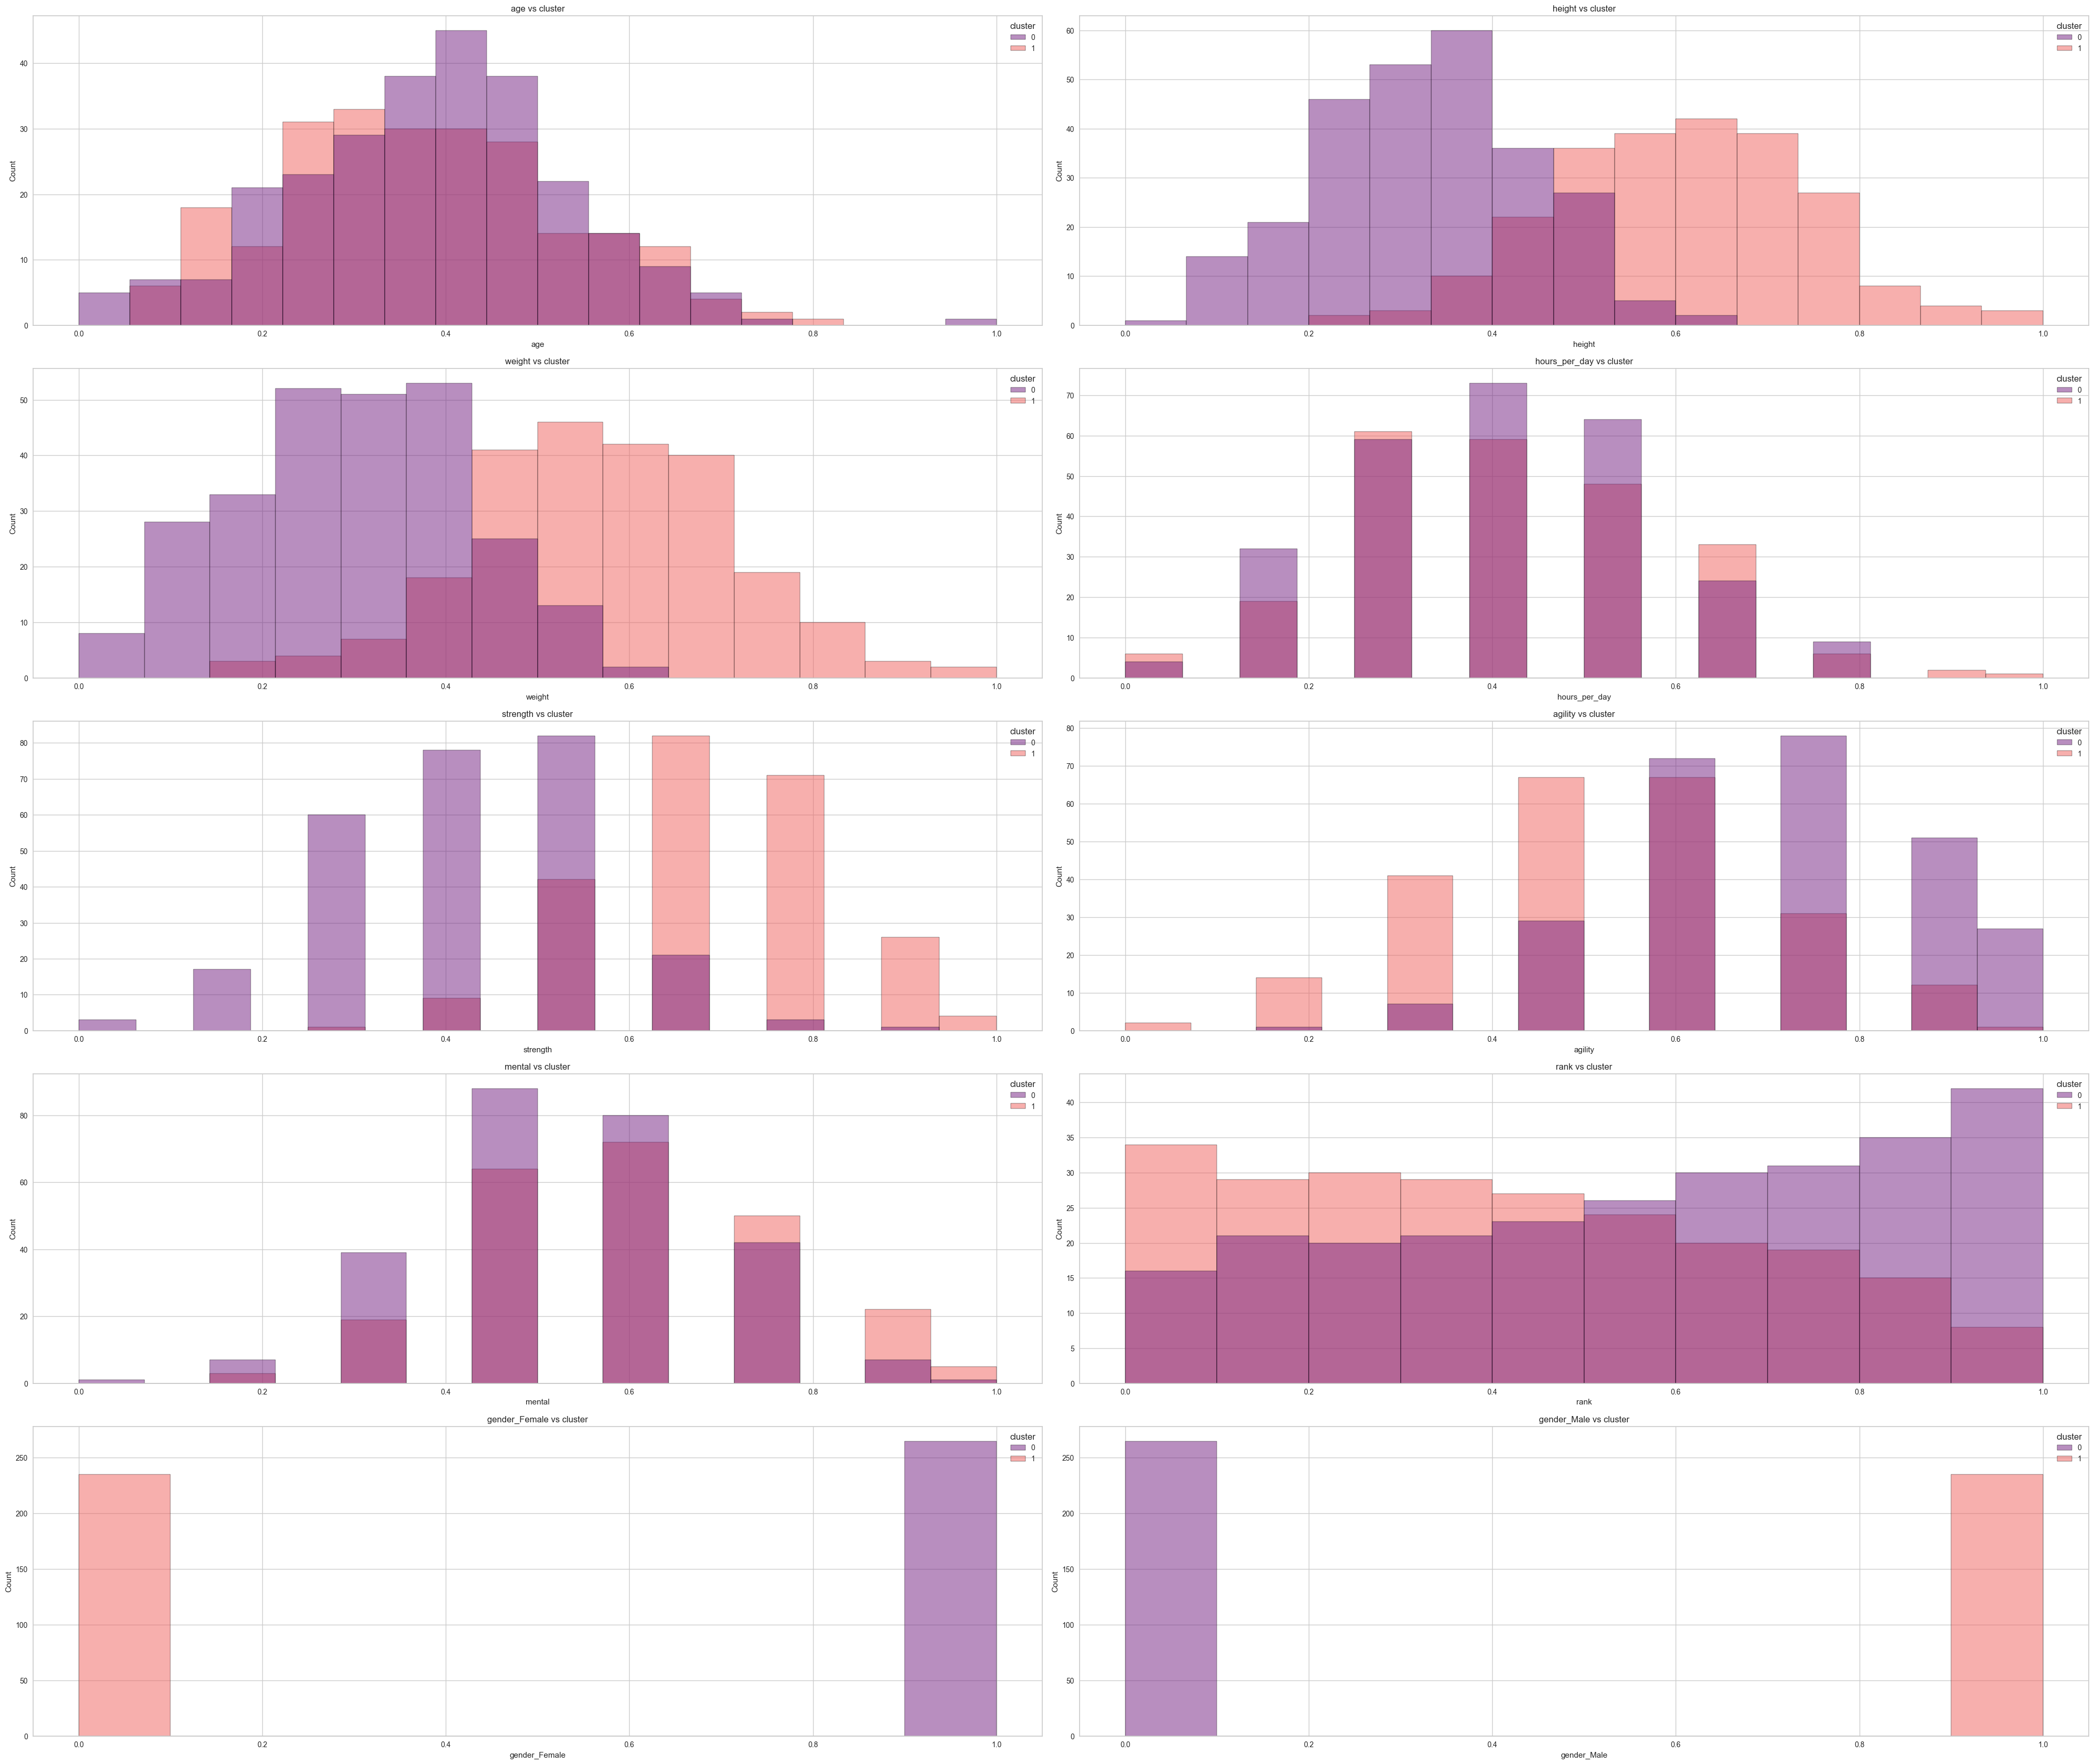

In [26]:
plot_relation_tv(df_agg.drop(columns=['nationality']), 'cluster', size=(40, 40), n_cols = 2)

As we can see, we obtain the same clusters as with the previous methods.

---

## DBSCAN Clustering

In [27]:
dbscan_methods(df_scaled, eps_values=[0.1, 0.5, 1], min_samples_values=[5, 10, 15, 20])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
8,1.0,5,0.541864,0.743419,"{0: 265, 1: 235}"
9,1.0,10,0.541864,0.743419,"{0: 265, 1: 235}"
10,1.0,15,0.541864,0.743419,"{0: 265, 1: 235}"
11,1.0,20,0.541864,0.743419,"{0: 265, 1: 235}"
4,0.5,5,0.428836,2.058583,"{-1: 2, 0: 265, 1: 233}"
6,0.5,15,0.424682,1.629460,"{-1: 18, 0: 222, 1: 260}"
5,0.5,10,0.404201,1.672351,"{-1: 8, 0: 228, 1: 264}"
7,0.5,20,0.245356,1.730500,"{-1: 27, 0: 166, 1: 189, 2: 53, 3: 65}"
0,0.1,5,-1.000000,NaN,{'Unique cluster': 500}
1,0.1,10,-1.000000,NaN,{'Unique cluster': 500}


### Apply best model

In [28]:
dbscan = DBSCAN(eps=1, min_samples=5, n_jobs=-1)

dbscan_labels = dbscan.fit_predict(df_scaled)

In [29]:
clustering_metrics(df_scaled, dbscan_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.541864,0.743419,265
1,0.541864,0.743419,235


In [30]:
df_dbscan = df_scaled.copy()
df_dbscan["cluster"] = dbscan_labels

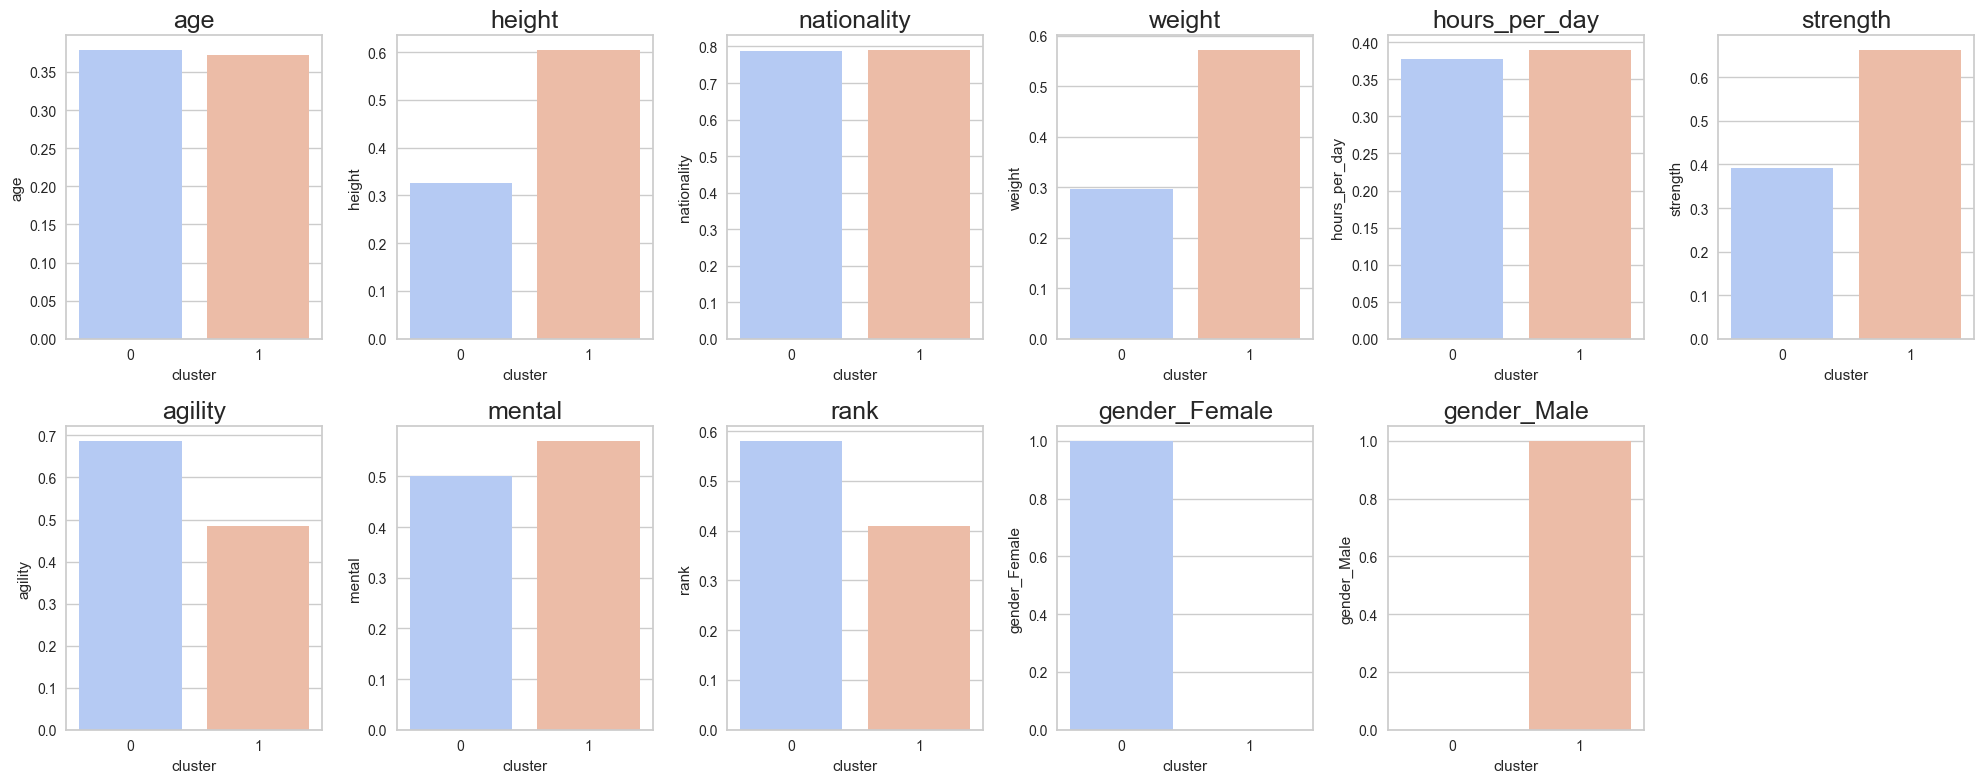

In [31]:
plot_clusters(df_dbscan)

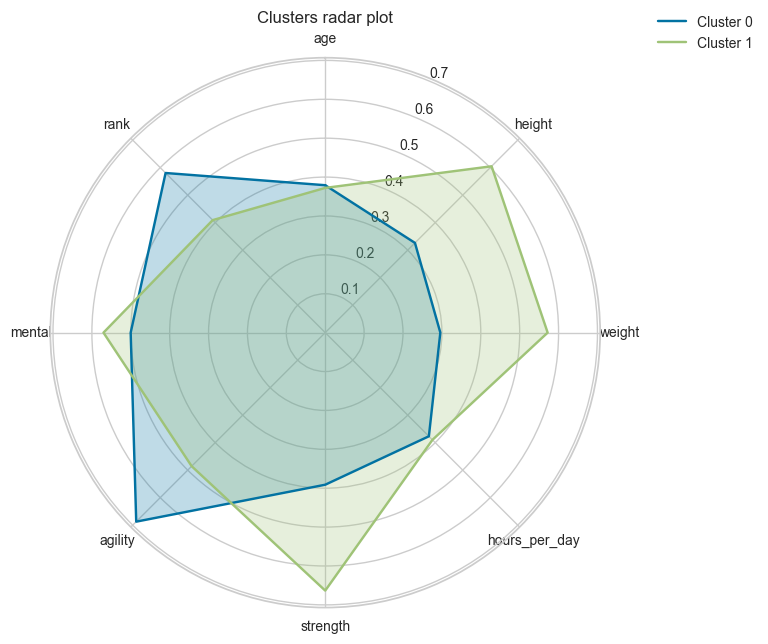

In [32]:
variables = ['age',
            'height',
            'weight',
            'hours_per_day',
            'strength',
            'agility',
            'mental',
            'rank']

plot_radar(df_dbscan, variables)

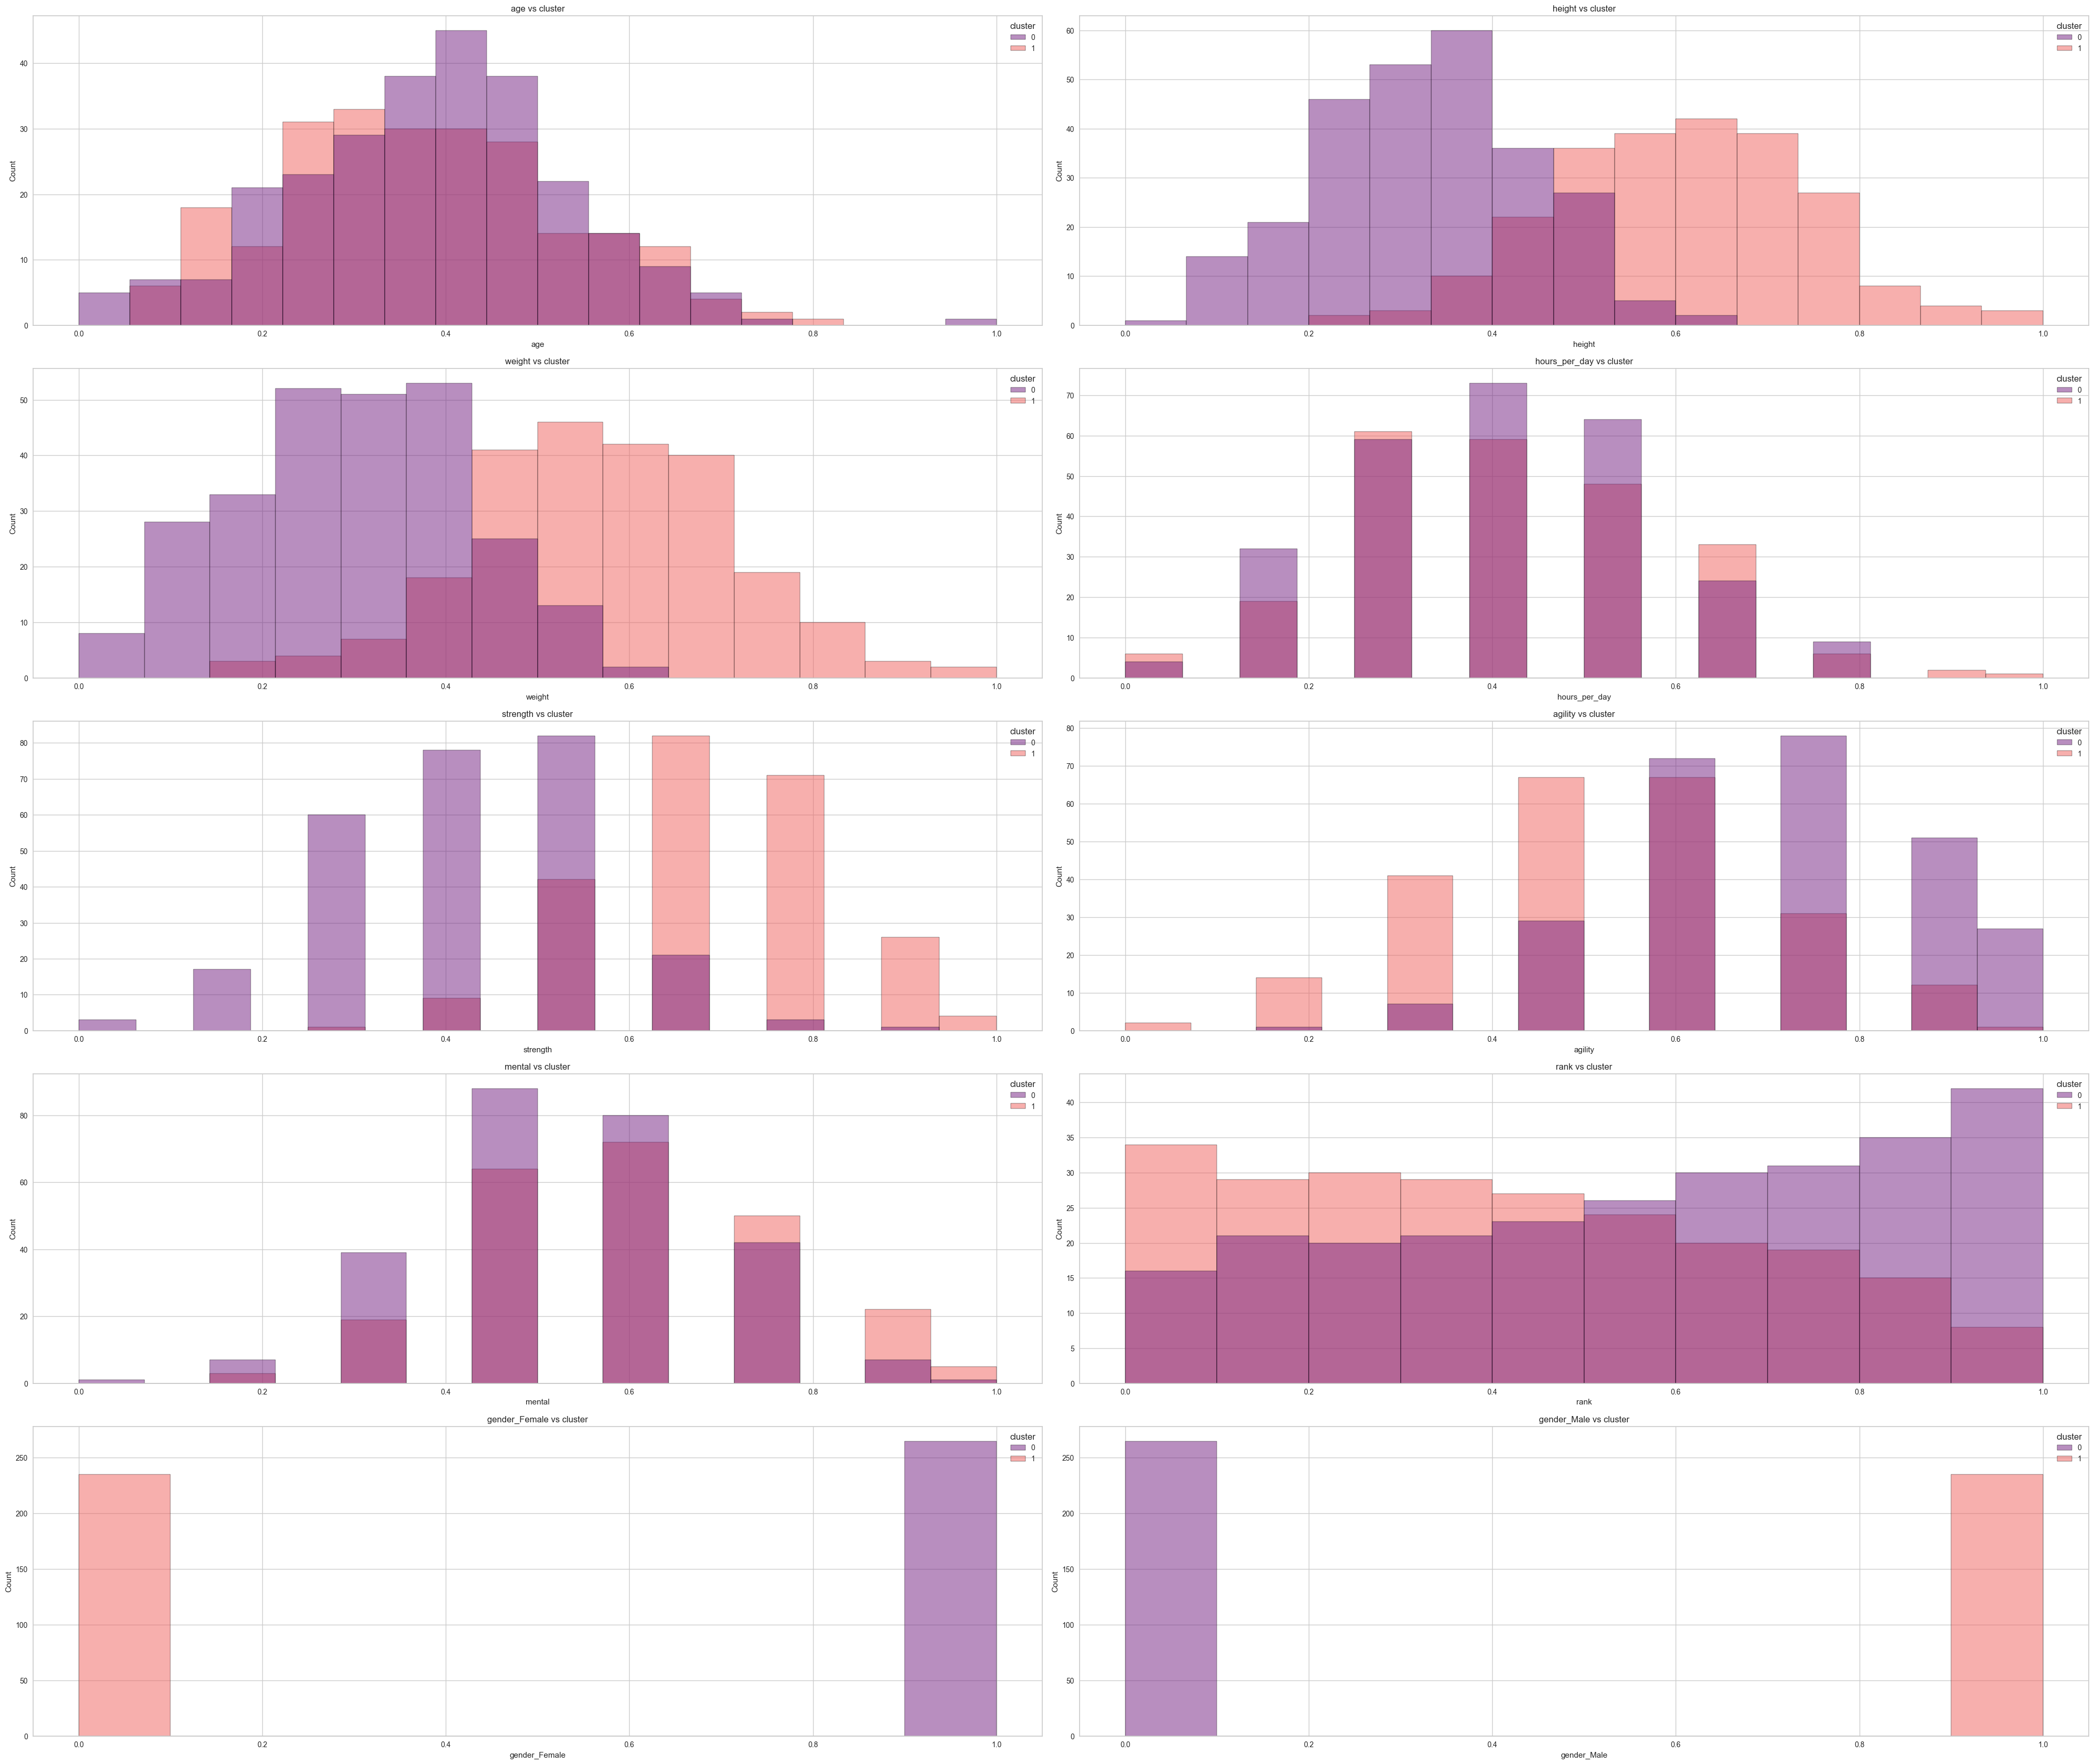

In [33]:
plot_relation_tv(df_dbscan.drop(columns=['nationality']), 'cluster', size=(40, 40), n_cols = 2)

---

## Conclusions

The analysis conducted using the clustering algorithms `K-Means`, `Agglomerative Clustering`, `Spectral Clustering`, and `DBSCAN` consistently identified two main clusters, which align with a separation between men and women. The agreement across different clustering methods strengthens the robustness of the result and suggests that the inherent structure of the dataset favors this division into two groups.

* There is a clear difference in physical aspects such as strength, agility, weight, height, and, to a lesser extent, mental resilience. Differences are also evident in performance in terms of ranking.

* These differences align with the findings of the exploratory analysis, which is expected since the groups were generated based on an explicit variable in the dataset.

* The separation into two clusters does not imply causation and should not be interpreted as a simplification of the differences between men and women in sports. Other factors, such as data bias, could influence this segmentation.

We conclude that unsupervised analysis can reveal latent patterns in the data and how these patterns reflect real aspects of the studied populations.

### Next Steps

- Subgroup analysis: Once separated by gender, a more granular analysis could be conducted within each cluster to identify additional patterns.

- Cross-validation: Perform a statistical analysis to confirm that the differences between the clusters are significant.
